Ejemplo de la documentación de NILMTK: 
https://github.com/nilmtk/nilmtk/blob/master/docs/manual/user_guide/disaggregation_and_metrics.ipynb

# Disaggregation and Metrics

In [2]:
from __future__ import print_function, division
import time
from matplotlib import rcParams
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
rcParams['figure.figsize'] = (13, 6)
plt.style.use('ggplot')

from nilmtk import DataSet, TimeFrame, MeterGroup, HDFDataStore

### Dividing data into train and test set

In [3]:
train = DataSet('data/redd.h5')
test = DataSet('data/redd.h5')

Let us use building 1 for demo purposes

In [4]:
building = 1

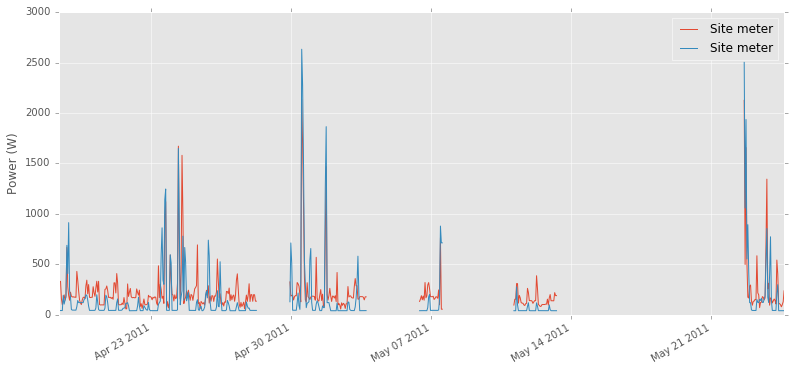

In [6]:
train.buildings[building].elec.mains().plot()

Let's split data at April 30th

In [7]:
train.set_window(end="30-4-2011")
test.set_window(start="30-4-2011")


train_elec = train.buildings[1].elec
test_elec = test.buildings[1].elec

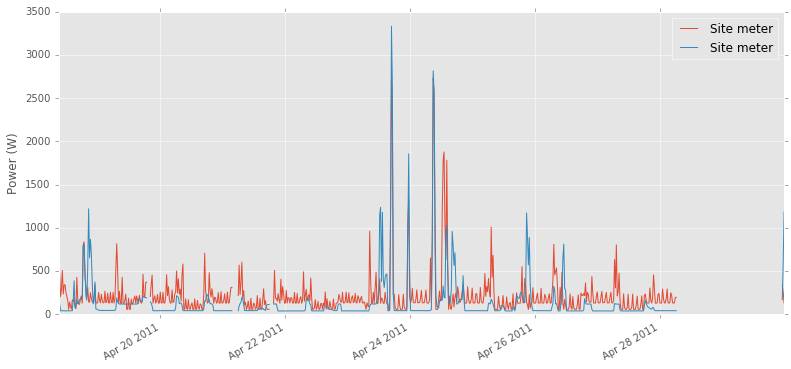

In [8]:
train_elec.mains().plot()

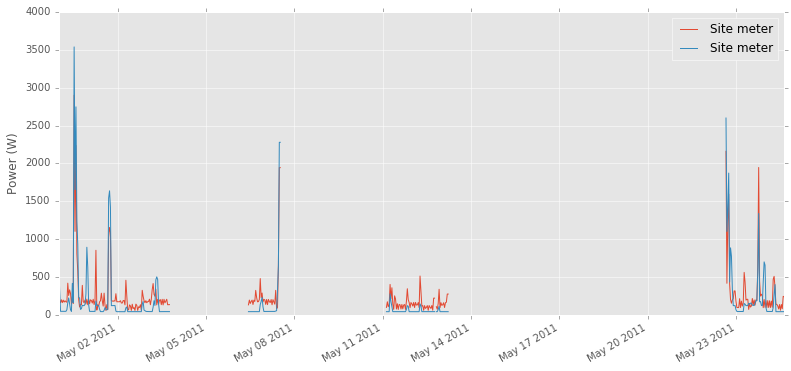

In [9]:
test_elec.mains().plot()

REDD data set has got appliance level data sampled every 3 or 4 seconds and mains data sampled every 1 second. Let us verify the same.

To allow disaggregation to be done on any arbitrarily large dataset, disaggregation output is dumped to disk chunk-by-chunk:

In [10]:
fridge_meter = train_elec['fridge']

In [11]:
fridge_df = fridge_meter.load().next()

In [12]:
fridge_df.head()

physical_quantity,power
type,active
2011-04-18 09:22:13-04:00,6
2011-04-18 09:22:16-04:00,6
2011-04-18 09:22:20-04:00,6
2011-04-18 09:22:23-04:00,6
2011-04-18 09:22:26-04:00,6


In [13]:
mains = train_elec.mains()

In [14]:
mains_df = mains.load().next()

Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     
Done loading data all meters for this chunk.


In [15]:
mains_df.head()

physical_quantity,power
type,apparent
2011-04-18 09:22:09-04:00,342.820007
2011-04-18 09:22:10-04:00,344.559998
2011-04-18 09:22:11-04:00,345.140015
2011-04-18 09:22:12-04:00,341.679993
2011-04-18 09:22:13-04:00,341.029999


Since, both of these are sampled at different frequencies, we will downsample both to 1 minute resolution. We will also select the top-5 appliances in terms of energy consumption and use them for training our FHMM and CO models.

### Selecting top-5 appliances

In [16]:
top_5_train_elec = train_elec.submeters().select_top_k(k=5)

15/16 MeterGroup(meters=
  ElecMeter(instance=3, building=1, dataset='REDD', appliances=[Appliance(type='electric oven', instance=1)])
  ElecMeter(instance=4, building=1, dataset='REDD', appliances=[Appliance(type='electric oven', instance=1)])
16/16 MeterGroup(meters=
  ElecMeter(instance=10, building=1, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
  ElecMeter(instance=20, building=1, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
Calculating total_energy for ElecMeterID(instance=20, building=1, dataset='REDD') ...   

In [17]:
top_5_train_elec

MeterGroup(meters=
  ElecMeter(instance=5, building=1, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])
  ElecMeter(instance=11, building=1, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])
  ElecMeter(instance=8, building=1, dataset='REDD', appliances=[Appliance(type='sockets', instance=2)])
  ElecMeter(instance=9, building=1, dataset='REDD', appliances=[Appliance(type='light', instance=1)])
  ElecMeter(instance=6, building=1, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])
)

### Training and disaggregation

#### FHMM

In [18]:
start = time.time()
from nilmtk.disaggregate import fhmm_exact
fhmm = fhmm_exact.FHMM()
# Note that we have given the sample period to downsample the data to 1 minute
fhmm.train(top_5_train_elec, sample_period=60)
end = time.time()
print("Runtime =", end-start, "seconds.")

Training model for submeter 'ElecMeter(instance=5, building=1, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])'
Training model for submeter 'ElecMeter(instance=11, building=1, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])'
Training model for submeter 'ElecMeter(instance=8, building=1, dataset='REDD', appliances=[Appliance(type='sockets', instance=2)])'
Training model for submeter 'ElecMeter(instance=9, building=1, dataset='REDD', appliances=[Appliance(type='light', instance=1)])'
Training model for submeter 'ElecMeter(instance=6, building=1, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])'
Runtime = 103.052575827 seconds.


In [20]:
disag_filename = 'data/redd-disag-fhmm.h5'
output = HDFDataStore(disag_filename, 'w')
# Note that we have mentioned to disaggregate after converting to a sample period of 60 seconds
fhmm.disaggregate(test_elec.mains(), output, sample_period=60)
output.close()

Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     
Done loading data all meters for this chunk.


In [21]:
disag_fhmm = DataSet(disag_filename)
disag_fhmm_elec = disag_fhmm.buildings[building].elec

In [22]:
from nilmtk.metrics import f1_score
f1_fhmm = f1_score(disag_fhmm_elec, test_elec)
f1_fhmm.index = disag_fhmm_elec.get_labels(f1_fhmm.index)

In [23]:
start = time.time()
from nilmtk.disaggregate import CombinatorialOptimisation
co = CombinatorialOptimisation()
# Note that we have given the sample period to downsample the data to 1 minute
co.train(top_5_train_elec, sample_period=60)
end = time.time()
print("Runtime =", end-start, "seconds.")

Training model for submeter 'ElecMeter(instance=5, building=1, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])'
Training model for submeter 'ElecMeter(instance=11, building=1, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])'
Training model for submeter 'ElecMeter(instance=8, building=1, dataset='REDD', appliances=[Appliance(type='sockets', instance=2)])'
Training model for submeter 'ElecMeter(instance=9, building=1, dataset='REDD', appliances=[Appliance(type='light', instance=1)])'
Training model for submeter 'ElecMeter(instance=6, building=1, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])'
Done training!
Runtime = 10.3951191902 seconds.


In [24]:
disag_filename = 'data/redd-disag-co.h5'
output = HDFDataStore(disag_filename, 'w')
# Note that we have mentioned to disaggregate after converting to a sample period of 60 seconds
co.disaggregate(test_elec.mains(), output, sample_period=60)
output.close()

Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Including vampire_power = 97.2488327026 watts to model...
Estimating power demand for 'ElecMeter(instance=5, building=1, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])'
Estimating power demand for 'ElecMeter(instance=11, building=1, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])'
Estimating power demand for 'ElecMeter(instance=8, building=1, dataset='REDD', appliances=[Appliance(type='sockets', instance=2)])'
Estimating power demand for 'ElecMeter(instance=9, building=1, dataset='REDD', appliances=[Appliance(type='light', instance=1)])'
Estimating power demand for 'ElecMeter(instance=6, building=1, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])'
Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Including vampire_power = 92

In [25]:
disag_co = DataSet(disag_filename)
disag_co_elec = disag_co.buildings[building].elec

In [26]:
from nilmtk.metrics import f1_score
f1_co= f1_score(disag_co_elec, test_elec)
f1_co.index = disag_co_elec.get_labels(f1_co.index)

In [27]:
f1=pd.concat([f1_fhmm,f1_co],axis=1)

In [28]:
f1
f1.columns=['fhmm','co']

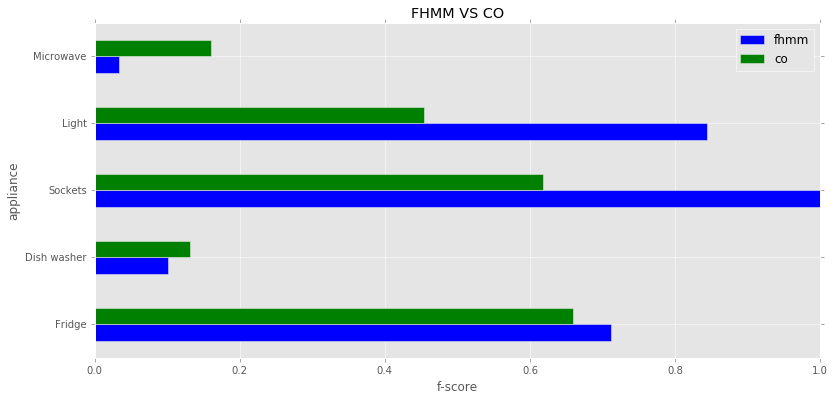

In [29]:
f1.plot(kind='barh')
plt.ylabel('appliance');
plt.xlabel('f-score');
plt.title("FHMM VS CO");